# Elastic Optical Network - Pre-Disaster Simulation Analysis (Refactored)

This notebook has been refactored to use modular analysis and visualization packages:

## Modules Used:

### Analysis (`simulador.analysis`)
- **`topology_analysis`**: Network structure analysis, critical disaster nodes
- **`metrics_calculator`**: Availability, blocking rates, performance metrics
- **`dataframe_filters`**: Data filtering by time, node, distance, components
- **`reporters`**: Formatted console output and reports

### Visualization (`simulador.visualization`)
- **`availability_plots`**: Availability charts and heatmaps
- **`traffic_plots`**: Traffic patterns and blocking visualizations

## Improvements:
- ✅ All inline functions removed
- ✅ Code reusable across notebooks
- ✅ Type hints and documentation
- ✅ Cleaner, more maintainable code

---


In [1]:
# Standard library
import math
import pickle
from collections import defaultdict

# Third-party
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from simpy import Environment

# Simulador - Core
from simulador import analysis
from simulador.main import Simulator
from simulador import Scenario, ScenarioGenerator, Metrics
from simulador.config.settings import NUMERO_DE_REQUISICOES, NUMERO_DE_SLOTS
from simulador import routing

# Simulador - Analysis
from simulador import analysis, visualization

# Simulador - Visualization
from simulador.visualization import (
    availability_plots,
    traffic_plots,
)

# Jupyter configuration
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load topology
TOPOLOGY = nx.read_weighted_edgelist("topology/usa", nodetype=int)

print("✓ All modules loaded successfully!")


✓ All modules loaded successfully!


### Encontra bons pontos de desastre para topologia

In [2]:
# Use topology analysis from module
results = analysis.topology_analysis.find_balanced_min_cut_for_all_nodes(TOPOLOGY)

# Extract critical node info from results
critical_info = results[0]
NODE_DESASTRE = critical_info["node"]
COMPONENTE_1 = critical_info["partitions"][0]["partition_1"]
COMPONENTE_2 = critical_info["partitions"][0]["partition_2"]
CRITICAL_EDGES = critical_info["partitions"][0]["cut_edges"]

# Print analysis
analysis.topology_analysis.print_topology_analysis_results(results[:5])

print(f"\nSelected disaster node: {NODE_DESASTRE}")
print(f"Component 1: {len(COMPONENTE_1)} nodes")
print(f"Component 2: {len(COMPONENTE_2)} nodes")
print(f"Critical edges: {len(CRITICAL_EDGES)}")


Node 9 removed: min_cut = 2, size_diff = 7
  Cut edges: [(6, 11), (8, 10)]
  Partition 1: [1, 2, 3, 4, 5, 6, 7, 8]
  Partition 2: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


Node 7 removed: min_cut = 2, size_diff = 15
  Cut edges: [(2, 3), (8, 10)]
  Partition 1: [8, 3, 4, 5]
  Partition 2: [1, 2, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


Node 17 removed: min_cut = 2, size_diff = 17
  Cut edges: [(14, 18), (22, 23)]
  Partition 1: [24, 18, 23]
  Partition 2: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22]


Node 6 removed: min_cut = 1, size_diff = 19
  Cut edges: [(2, 3)]
  Partition 1: [1, 2]
  Partition 2: [3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


Node 3 removed: min_cut = 2, size_diff = 19
  Cut edges: [(1, 6), (2, 6)]
  Partition 1: [1, 2]
  Partition 2: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  Cut edges: [(7, 4), (5, 8)]
  Partition 1:

### Cria cenario

In [3]:
criar_e_rodar_novo_cenario = True
is_logger_active = True

In [4]:
if criar_e_rodar_novo_cenario:
    roteamentos_a_serem_testados = [
        # routing.FirstFit,
        # routing.FirstFitDisasterAware,
        routing.FirstFitSubnet,
        routing.FirstFitWeightedSubnetDisasterAware,
    ]

    cenario1, cenario2 = ScenarioGenerator.gerar_cenarios(
        TOPOLOGY,
        retorna_lista_de_requisicoes=True,
        numero_de_requisicoes=NUMERO_DE_REQUISICOES,
        lista_de_roteamentos_de_desastre=roteamentos_a_serem_testados,
        disaster_node=NODE_DESASTRE,
    )

    # Save scenarios
    with open("output/cenario1.pkl", "wb") as file:
        pickle.dump(cenario1, file)

    with open("output/cenario2.pkl", "wb") as file:
        pickle.dump(cenario2, file)
else:
    # Load existing scenarios
    with open("output/cenario1.pkl", "rb") as file:
        cenario1 = pickle.load(file)

    with open("output/cenario2.pkl", "rb") as file:
        cenario2 = pickle.load(file)


Link  9 12  vai falhar
Link  9 11  vai falhar
Link  9 10  vai falhar
Link  9 6  vai falhar
Link  9 7  vai falhar
Link  9 10  vai falhar
Link  9 11  vai falhar
Link  9 12  vai falhar
node_desastre 9


### Roda cenarios

In [5]:
if criar_e_rodar_novo_cenario:
    # roda cenario1
    Metrics.reseta_registrador()
    env = Environment()
    simulador: Simulator = Simulator(
        env=env, topology=TOPOLOGY, status_logger=is_logger_active, cenario=cenario1
    )
    simulador.run()
    dataframe_cenario1 = simulador.salvar_dataframe("output/df_cenario1")
    dataframe_sliding_window = Metrics.cria_dataframe_janela_deslizante(
        "output/dataset1"
    )
    dataframe_media_disponibilidade_extra_componente = (
        Metrics.cria_dataframe_media_taxa_de_disponibilidade_extra_componente(
            "output/dataset1"
        )
    )
    dataframe_bloqueio_artificial = Metrics.cria_dataframe_bloqueio_artificial(
        "output/dataset1"
    )
dataframe1: pd.DataFrame = pd.read_csv("output/df_cenario1.csv")


10000 requests processed, time : 96
20000 requests processed, time : 191
30000 requests processed, time : 274
40000 requests processed, time : 342
50000 requests processed, time : 406
60000 requests processed, time : 471
70000 requests processed, time : 534
Link 9 -> 12 falhou no tempo 597
80000 requests processed, time : 598
Node 9 falhou no tempo 611
Link 9 -> 11 falhou no tempo 621
Link 9 -> 10 falhou no tempo 627
90000 requests processed, time : 695
Link 9 -> 12 falhou no tempo 784
Node 9 falhou no tempo 784
Link 9 -> 11 falhou no tempo 784
Disaster finalizado no tempo 784
Link 9 -> 10 falhou no tempo 784
100000 requests processed, time : 791
110000 requests processed, time : 888
120000 requests processed, time : 984
130000 requests processed, time : 1080
140000 requests processed, time : 1175


/var/folders/0k/s6m7zdf54hgbxnlcw473w_1h0000gq/T/ipykernel_343/1469711314.py:21: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe1: pd.DataFrame = pd.read_csv("output/df_cenario1.csv")


In [6]:
tempo_fim_migracao_concluida1 = Metrics.get_intance().tempo_de_migracao_concluida

In [7]:
if criar_e_rodar_novo_cenario:
    # roda cenario2
    env = Environment()
    Metrics.reseta_registrador()
    simulador: Simulator = Simulator(
        env=env, topology=TOPOLOGY, status_logger=is_logger_active, cenario=cenario2
    )
    simulador.run()
    dataframe2_sliding_window = Metrics.cria_dataframe_janela_deslizante(
        "output/dataset2"
    )
    dataframe2_media_disponibilidade_extra_componente = (
        Metrics.cria_dataframe_media_taxa_de_disponibilidade_extra_componente(
            "output/dataset2"
        )
    )
    dataframe_cenario2 = simulador.salvar_dataframe("output/df_cenario2")
    dataframe2_bloqueio_artificial = Metrics.cria_dataframe_bloqueio_artificial(
        "output/dataframe2"
    )


dataframe2: pd.DataFrame = pd.read_csv("output/df_cenario2.csv")

10000 requests processed, time : 96
20000 requests processed, time : 191
30000 requests processed, time : 274
40000 requests processed, time : 342
50000 requests processed, time : 406
60000 requests processed, time : 471
70000 requests processed, time : 534
Link 9 -> 12 falhou no tempo 597
80000 requests processed, time : 598
Node 9 falhou no tempo 611
Link 9 -> 11 falhou no tempo 621
Link 9 -> 10 falhou no tempo 627
90000 requests processed, time : 695
Link 9 -> 12 falhou no tempo 784
Node 9 falhou no tempo 784
Link 9 -> 11 falhou no tempo 784
Disaster finalizado no tempo 784
Link 9 -> 10 falhou no tempo 784
100000 requests processed, time : 791
110000 requests processed, time : 888
120000 requests processed, time : 984
130000 requests processed, time : 1080
140000 requests processed, time : 1175


/var/folders/0k/s6m7zdf54hgbxnlcw473w_1h0000gq/T/ipykernel_343/2979322305.py:23: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe2: pd.DataFrame = pd.read_csv("output/df_cenario2.csv")


In [8]:
tempo_fim_migracao_concluida2 = Metrics.get_intance().tempo_de_migracao_concluida

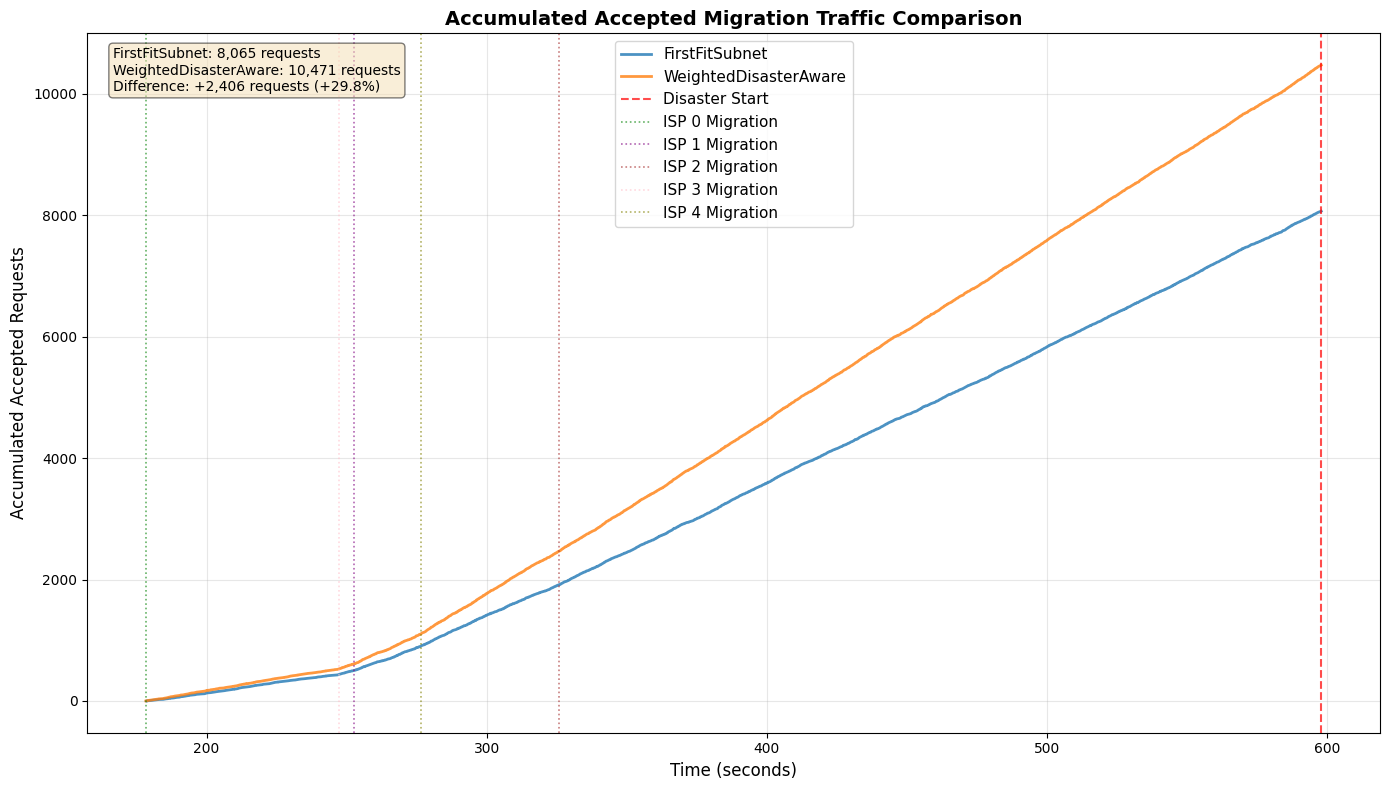

In [9]:
from simulador.visualization.accumulated_traffic import plot_accumulated_accepted_traffic

fig = plot_accumulated_accepted_traffic(
    dataframe1,
    dataframe2,
    label1="FirstFitSubnet",
    label2="WeightedDisasterAware",
    traffic_type="migration",  # "all", "migration", or "normal"
    metric="requests",         # "bandwidth" or "requests"
    scenario1=cenario1          # Required for disaster start and ISP migrations
)

In [10]:
for isp in cenario1.lista_de_isps:
    print(f"ISP {isp.isp_id} reaction time: {isp.datacenter.tempo_de_reacao}to {isp.datacenter.destination}")

isp_appearances = defaultdict(bool)
for i, req in enumerate(cenario1.lista_de_requisicoes):
    if req.requisicao_de_migracao:
        if not isp_appearances[req.src_isp_index]:
            print( f"ISP {req.src_isp_index} first enqueued migration at {req.tempo_criacao} at index {i}")
            isp_appearances[req.src_isp_index] = True


for i in range(0, 5):
    first_migration = dataframe1[
        (dataframe1["requisicao_de_migracao"]==True)
         & (dataframe1["src_isp_index"] == i)
    ].sort_values(by="tempo_criacao").head(1)
    
    if not first_migration.empty:
        tempo = first_migration["tempo_criacao"].values[0]
        index = first_migration["Index da Requisição"].values[0]
        print(f"ISP {i}: First migration at {tempo:.2f}s index {index} from {first_migration['src'].values[0]} to {first_migration['dst'].values[0]}")


ISP 0 reaction time: 178.2164131663996to 5
ISP 1 reaction time: 252.74937683959428to 23
ISP 2 reaction time: 325.84705851671987to 24
ISP 3 reaction time: 247.19491988542325to 1
ISP 4 reaction time: 276.65690999233084to 17
ISP 0 first enqueued migration at 178.36017096332859 at index 18515
ISP 3 first enqueued migration at 247.22049116889025 at index 26310
ISP 1 first enqueued migration at 252.82545802243698 at index 27001
ISP 4 first enqueued migration at 276.69230854530565 at index 30270
ISP 2 first enqueued migration at 325.8807451831247 at index 37397
ISP 0: First migration at 178.36s index 18516 from 9 to 5
ISP 1: First migration at 252.83s index 27002 from 9 to 23
ISP 2: First migration at 325.88s index 37398 from 9 to 24
ISP 3: First migration at 247.22s index 26311 from 9 to 1
ISP 4: First migration at 276.69s index 30271 from 9 to 17


In [11]:
dataframe1[
        (dataframe1["requisicao_de_migracao"]==True)
         & (dataframe1["src_isp_index"] == 0)
    ]



,Unnamed: 0,Index da Requisição,src,dst,src_isp_index,dst_isp_index,bandwidth,class_type,holding_time,requisicao_de_migracao,bloqueada,afetada_por_desastre,numero_de_slots,caminho,tamanho_do_caminho,index_de_inicio_e_final,tempo_criacao,tempo_desalocacao,distacia,dados_pre_reroteamento
18515,18515,18516,9,5,0,0,350,3,1.054267,True,True,False,NaN,NaN,NaN,NaN,178.360171,NaN,NaN,NaN
18527,18527,18528,9,5,0,0,350,3,0.991824,True,False,False,28.0,"[9, 7, 4, 5]",4.0,"(114, 141)",178.506009,179.497834,2650.0,NaN
18530,18530,18531,9,5,0,0,200,2,0.910197,True,False,False,16.0,"[9, 7, 4, 5]",4.0,"(142, 157)",178.513851,179.424047,2650.0,NaN
18540,18540,18541,9,5,0,0,300,3,1.052706,True,True,False,NaN,NaN,NaN,NaN,178.671714,NaN,NaN,NaN
18568,18568,18569,9,5,0,0,150,2,1.116212,True,False,False,12.0,"[9, 7, 4, 5]",4.0,"(182, 193)",178.910713,180.026925,2650.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79854,79854,79855,9,5,0,0,300,3,1.043312,True,False,True,24.0,"[9, 10, 8, 5]",4.0,"(118, 141)",597.442146,599.040598,3100.0,"('79855', {'src': 9, 'dst': 5, 'src_isp_index'..."
79874,79874,79875,9,5,0,0,400,3,1.195671,True,False,True,32.0,"[9, 7, 3, 4, 5]",5.0,"(160, 191)",597.600841,599.192957,3050.0,"('79875', {'src': 9, 'dst': 5, 'src_isp_index'..."
79909,79909,79910,9,5,0,0,150,1,0.992567,True,False,True,12.0,"[9, 7, 4, 5]",4.0,"(112, 123)",597.791853,598.989852,2650.0,"('79910', {'src': 9, 'dst': 5, 'src_isp_index'..."
79932,79932,79933,9,5,0,0,100,3,1.009771,True,False,True,8.0,"[9, 7, 4, 5]",4.0,"(124, 131)",597.934263,599.007057,2650.0,"('79933', {'src': 9, 'dst': 5, 'src_isp_index'..."


In [12]:
# Define disaster timing constants

DISASTER_START = cenario1.desastre.start

DISASTER_END = cenario1.desastre.start + cenario1.desastre.duration

print(f"Disaster period: {DISASTER_START} - {DISASTER_END}")


Disaster period: 597.9972858216696 - 784.9461464242036


In [13]:
ACTION_START_TIME = {
    isp.isp_id: isp.datacenter.tempo_de_reacao for isp in cenario1.lista_de_isps
}
DISASTER_START_TIME = min(
    [(isp.datacenter.tempo_de_reacao, isp.isp_id) for isp in cenario1.lista_de_isps]
)[0]
DISASTER_END_TIME = cenario1.desastre.start + cenario1.desastre.duration

/Users/claudio.faria/Library/Caches/pypoetry/virtualenvs/simulador-eon-pre-desastre-cLZF9wpT-py3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


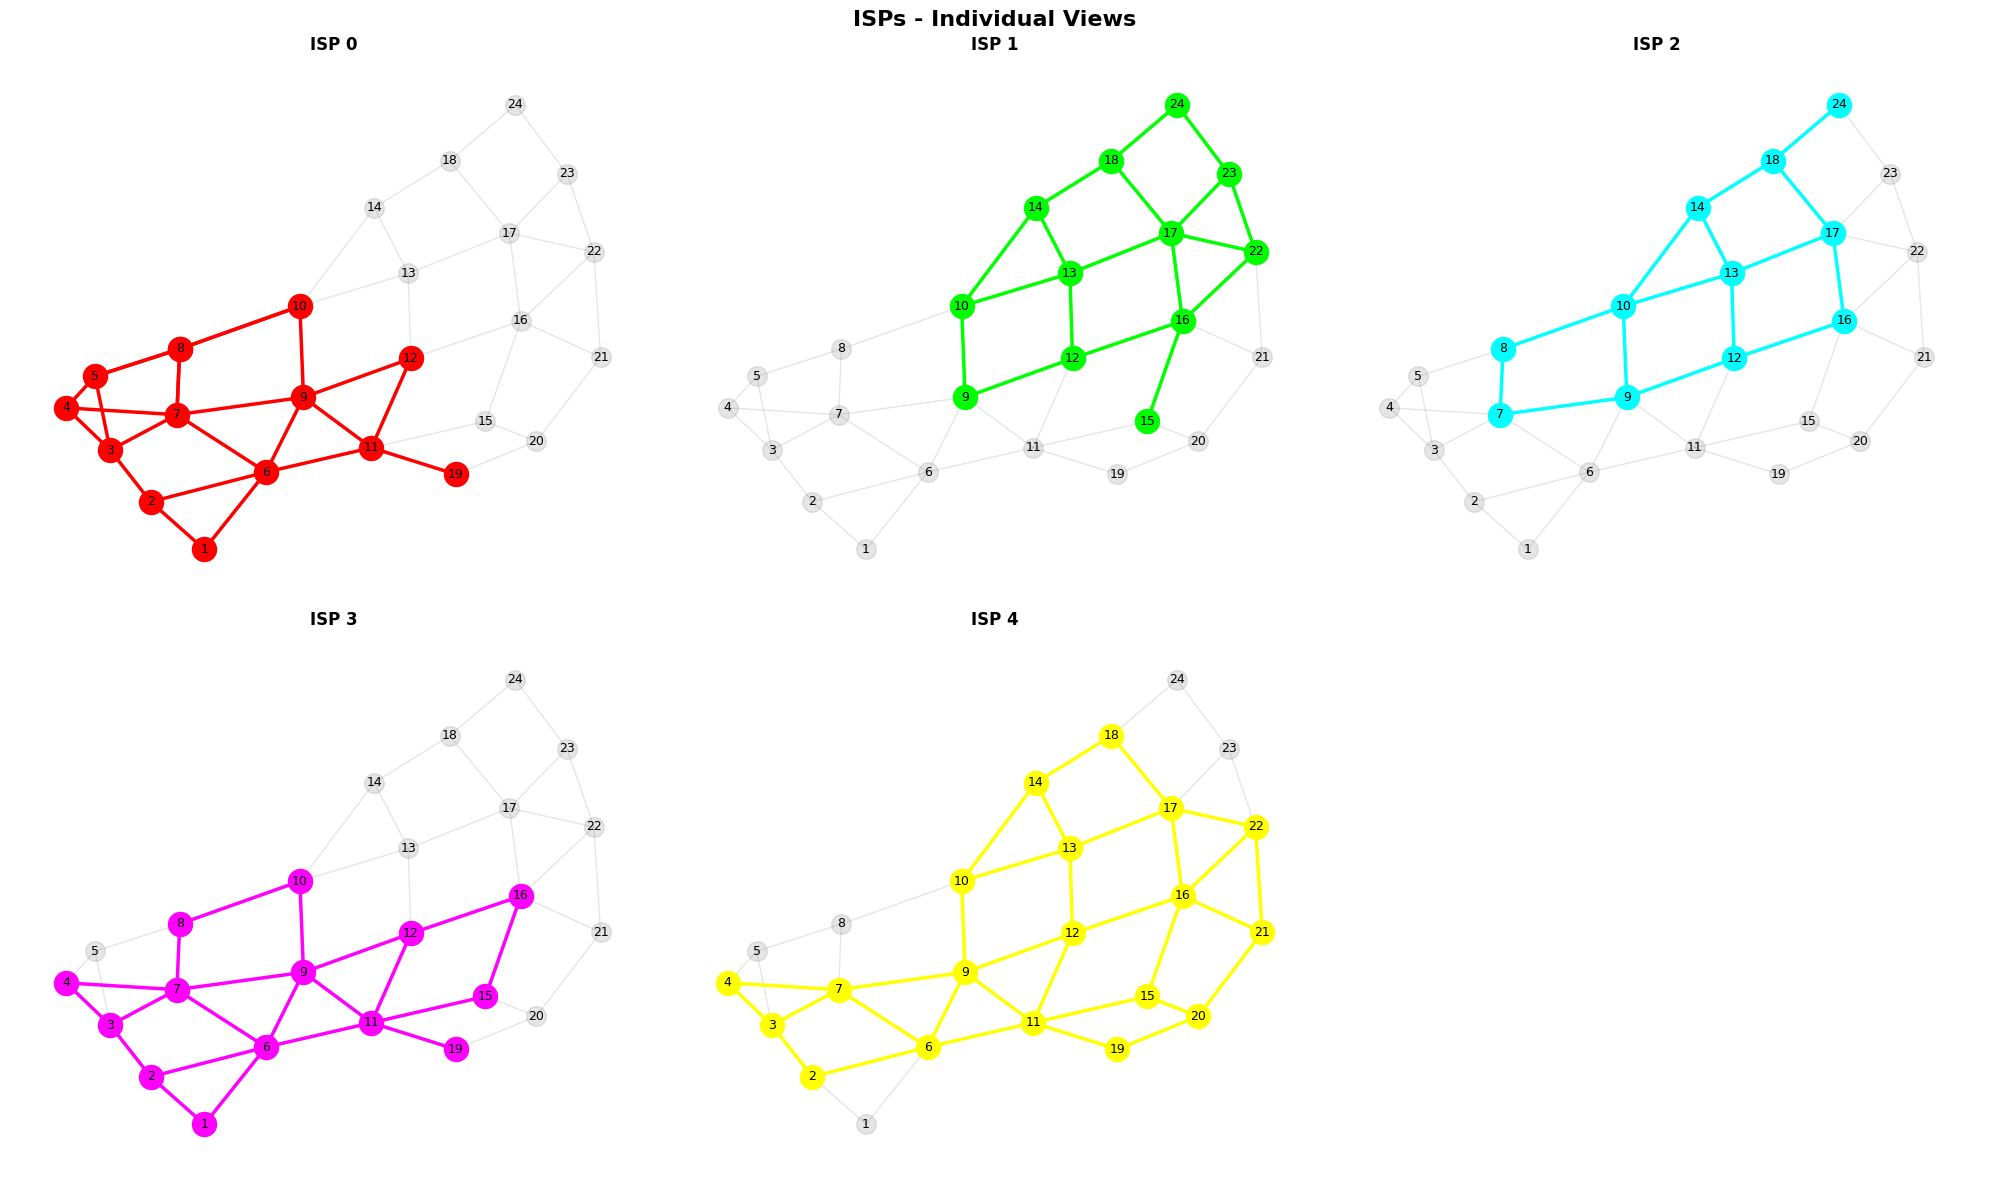

In [14]:
visualization.topology_plots.plot_isps_separately(
    TOPOLOGY,
    isp_data=cenario1,
    seed=7
)

### Plotagem de Dados Finais

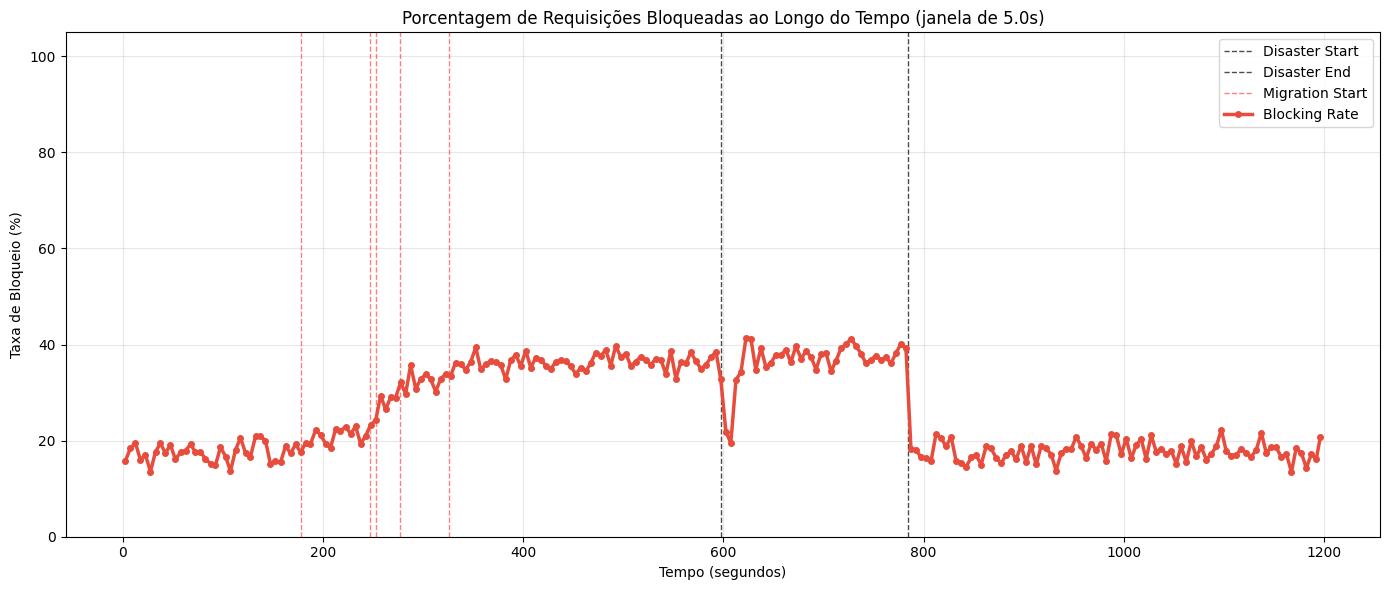

In [15]:
visualization.traffic_plots.plot_blocking_percentage_over_time(
    dataframe1,
    scenario=cenario1,

)

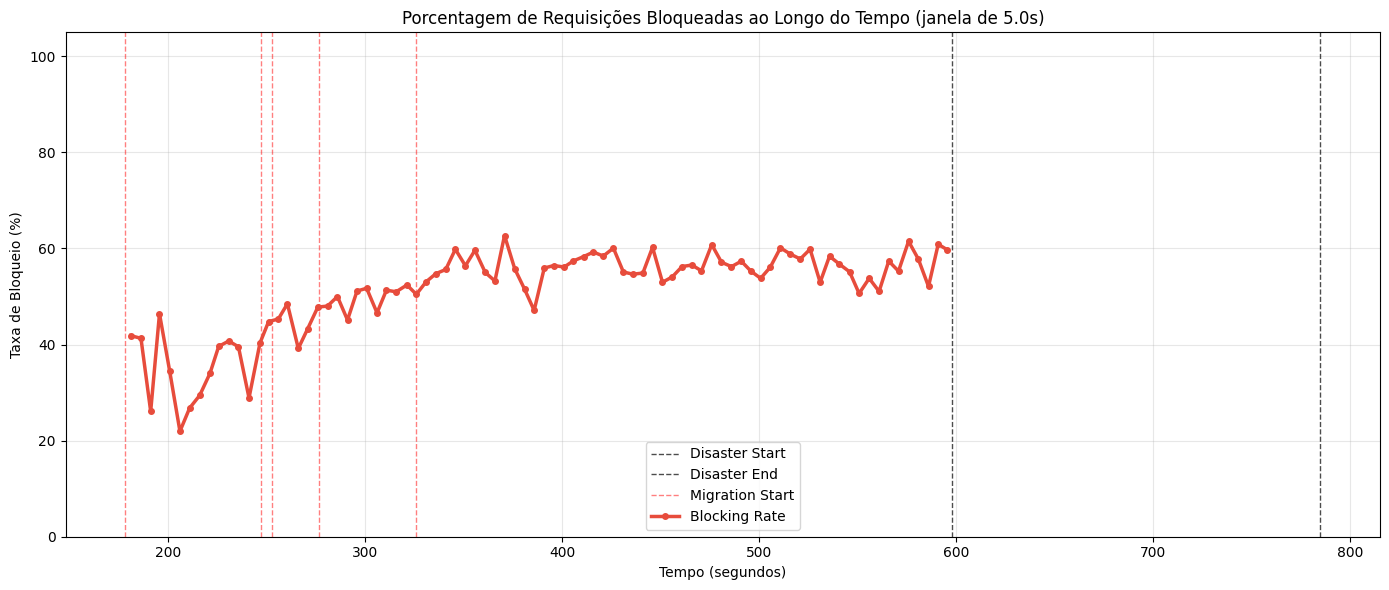

In [16]:
visualization.traffic_plots.plot_blocking_percentage_over_time(
    dataframe1[dataframe1["requisicao_de_migracao"]==True],
    scenario=cenario1,

)

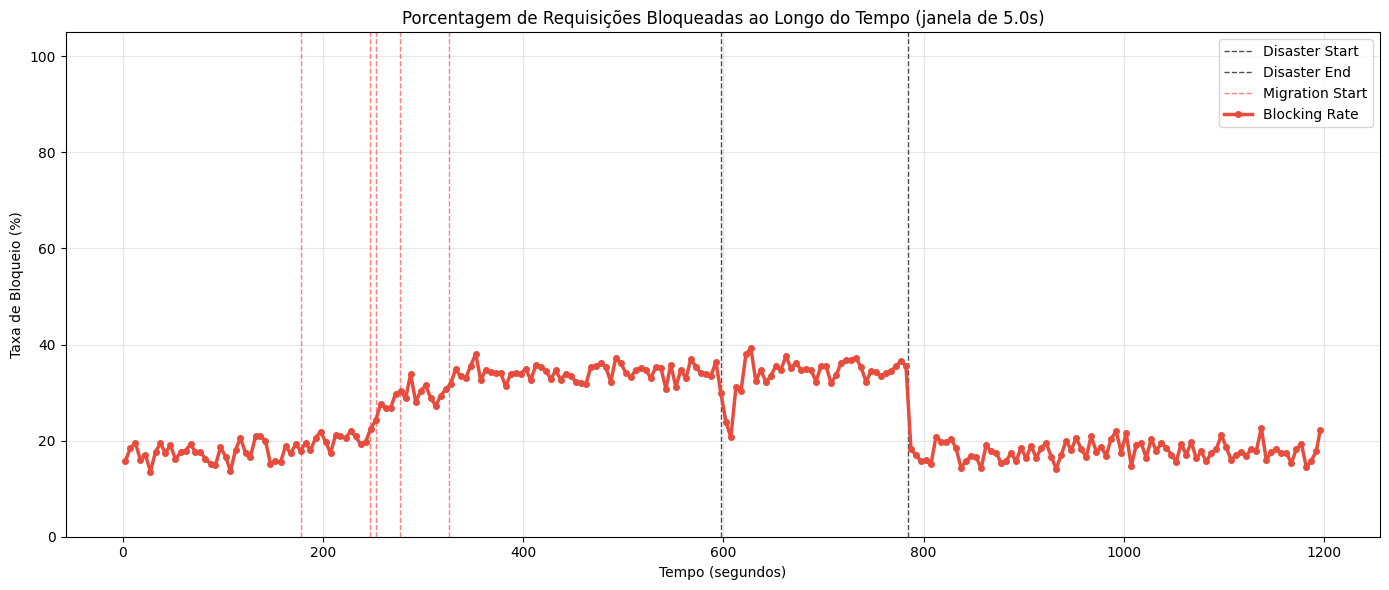

In [17]:
visualization.traffic_plots.plot_blocking_percentage_over_time(
    dataframe2,
    scenario=cenario2,

)

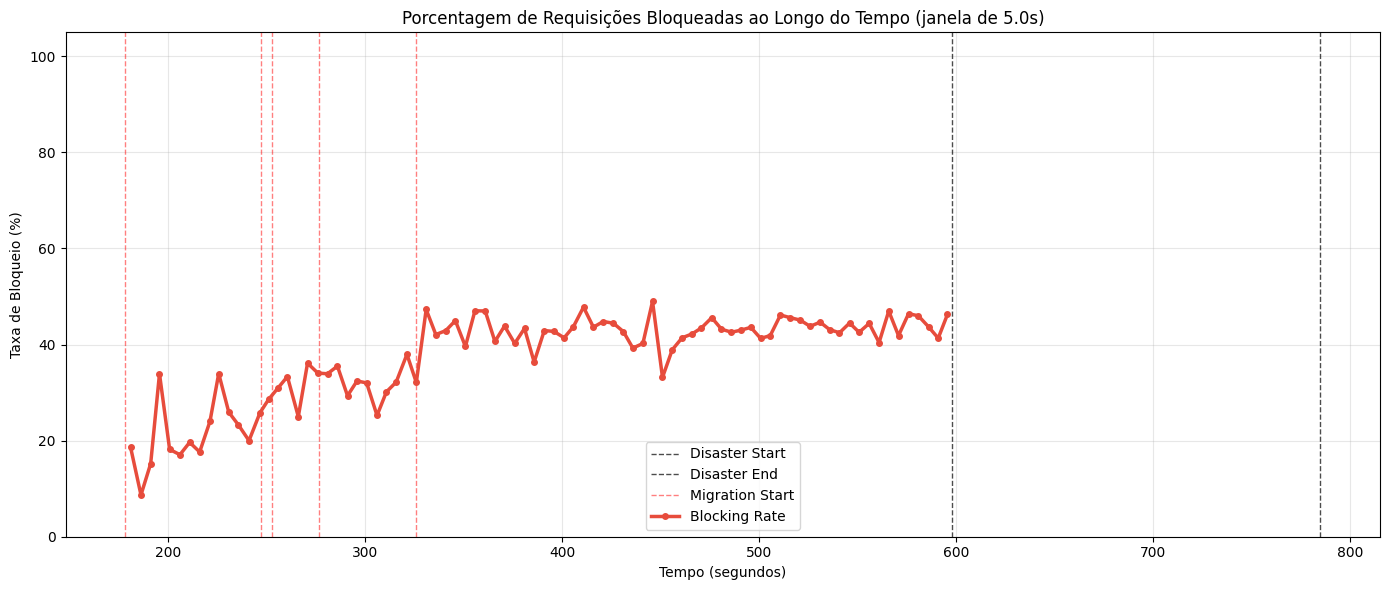

In [18]:
visualization.traffic_plots.plot_blocking_percentage_over_time(
    dataframe2[dataframe2["requisicao_de_migracao"]==True],
    scenario=cenario1,

)

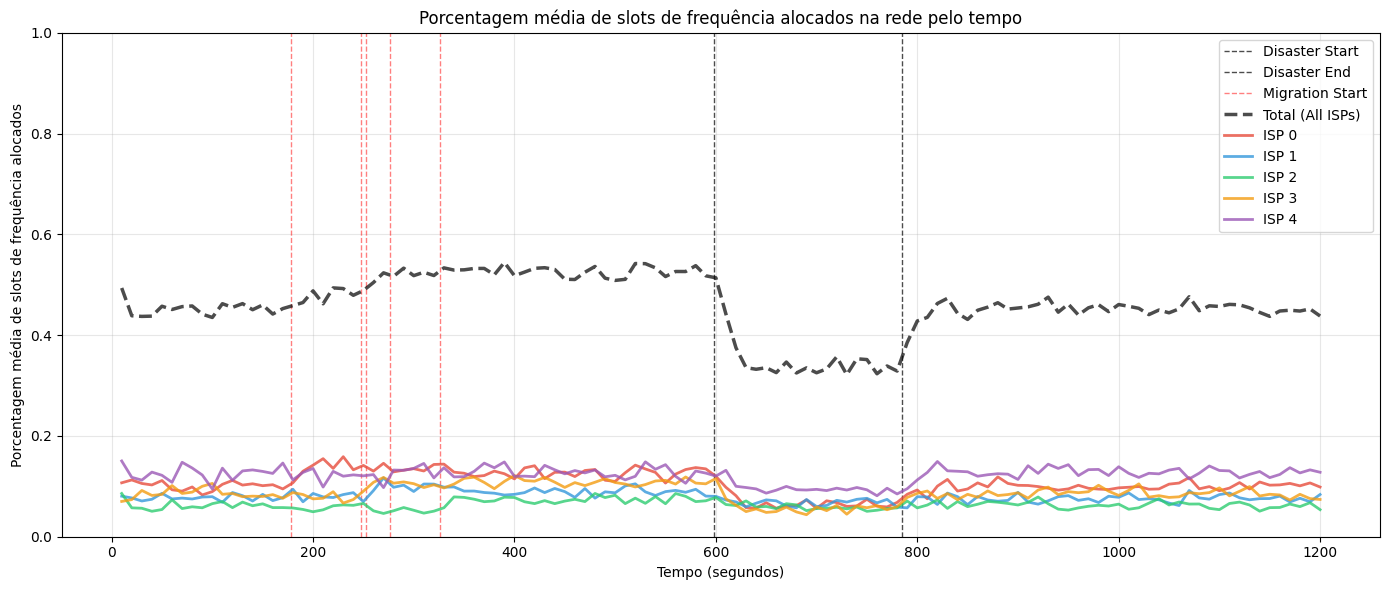

In [19]:
visualization.traffic_plots.plot_network_usage(dataframe1, TOPOLOGY, NUMERO_DE_SLOTS, scenario=cenario1, show_per_isp=True, )

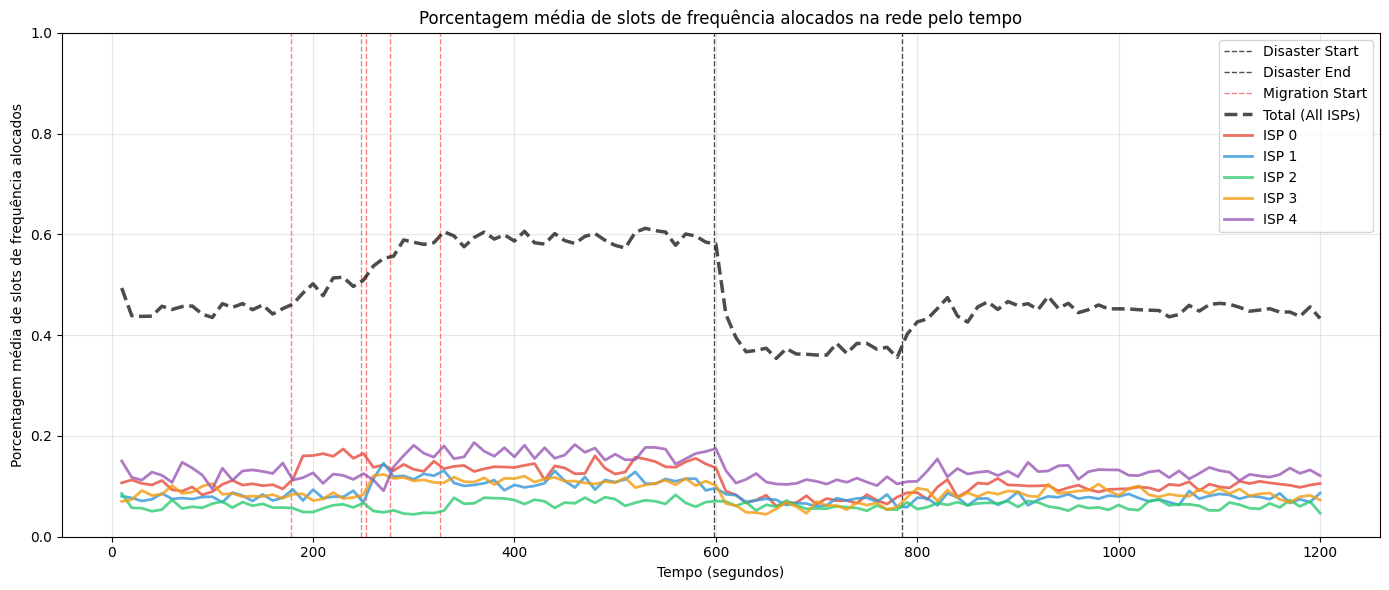

In [20]:
visualization.traffic_plots.plot_network_usage(dataframe2, TOPOLOGY, NUMERO_DE_SLOTS, scenario=cenario2, show_per_isp=True, )

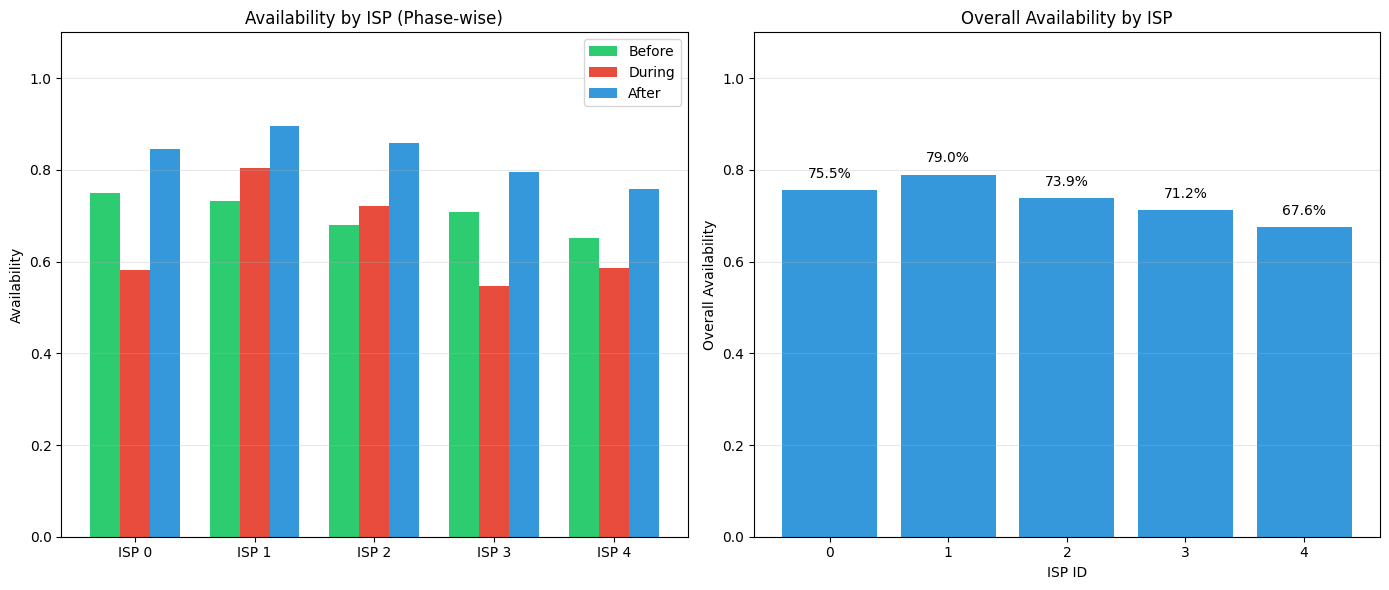

In [21]:
visualization.availability_plots.plot_availability_by_isp(dataframe1, cenario1, DISASTER_START, DISASTER_END)
#visualization.availability_plots.plot_isp_traffic_comparison(dataframe1, cenario1)

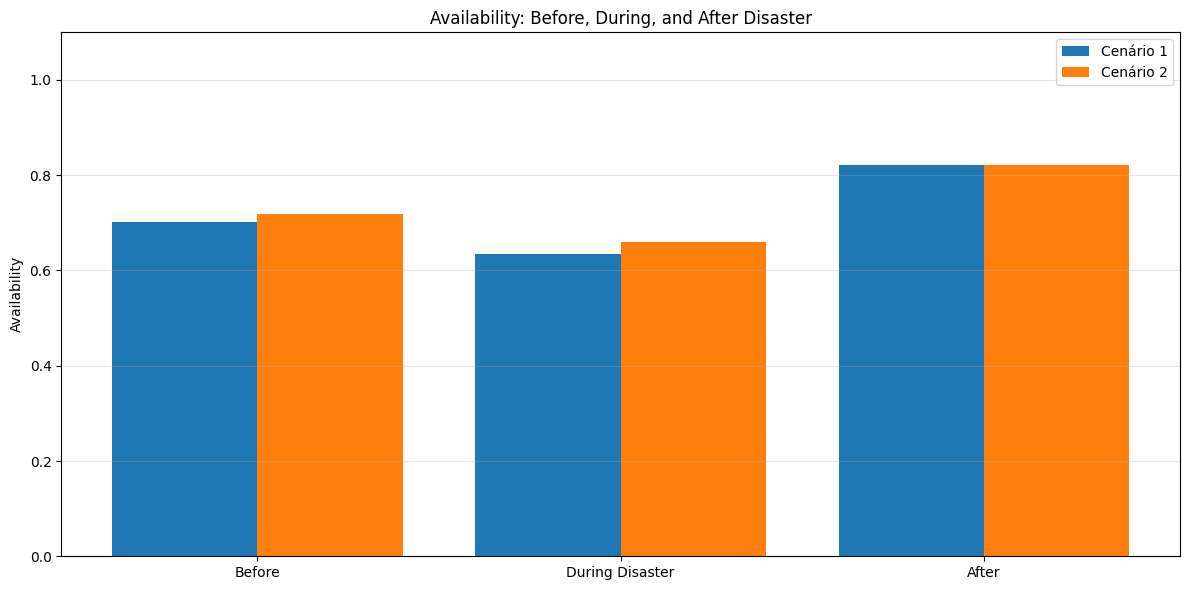

In [22]:
visualization.availability_plots.plot_availability_before_during_after({"Cenário 1": dataframe1, "Cenário 2": dataframe2}, DISASTER_START, DISASTER_END)

plt.show()


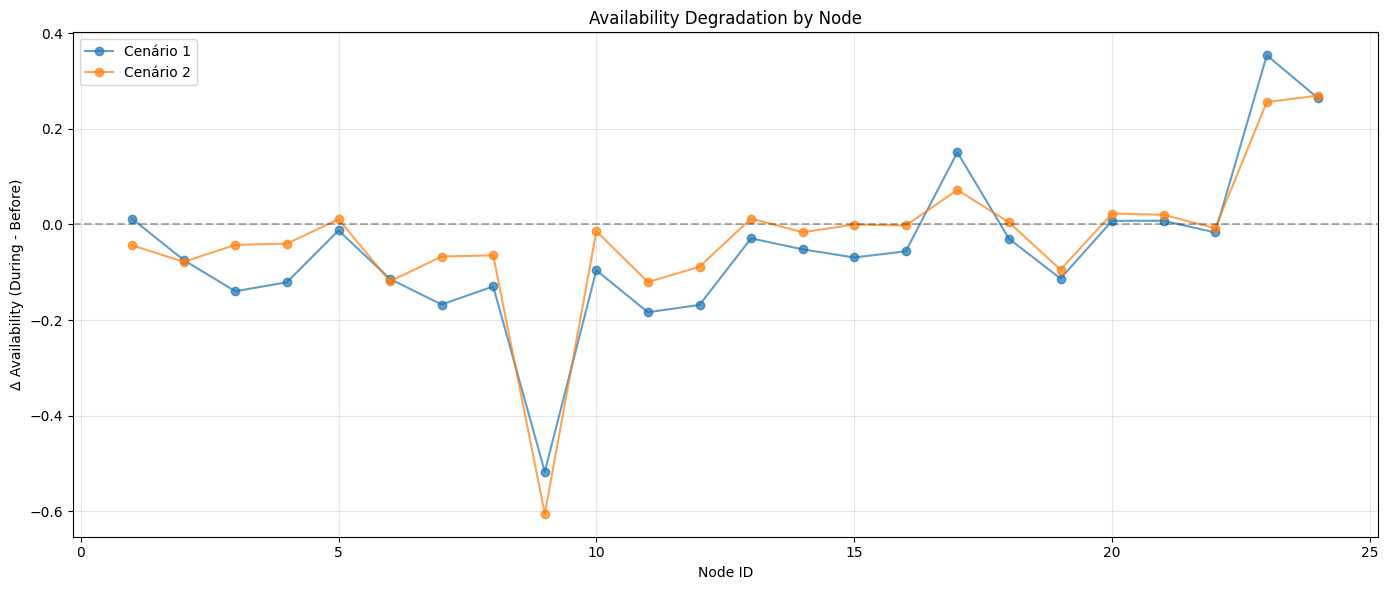

In [23]:
visualization.availability_plots.plot_delta_availability({"Cenário 1": dataframe1, "Cenário 2": dataframe2}, DISASTER_START, DISASTER_END)

plt.show()


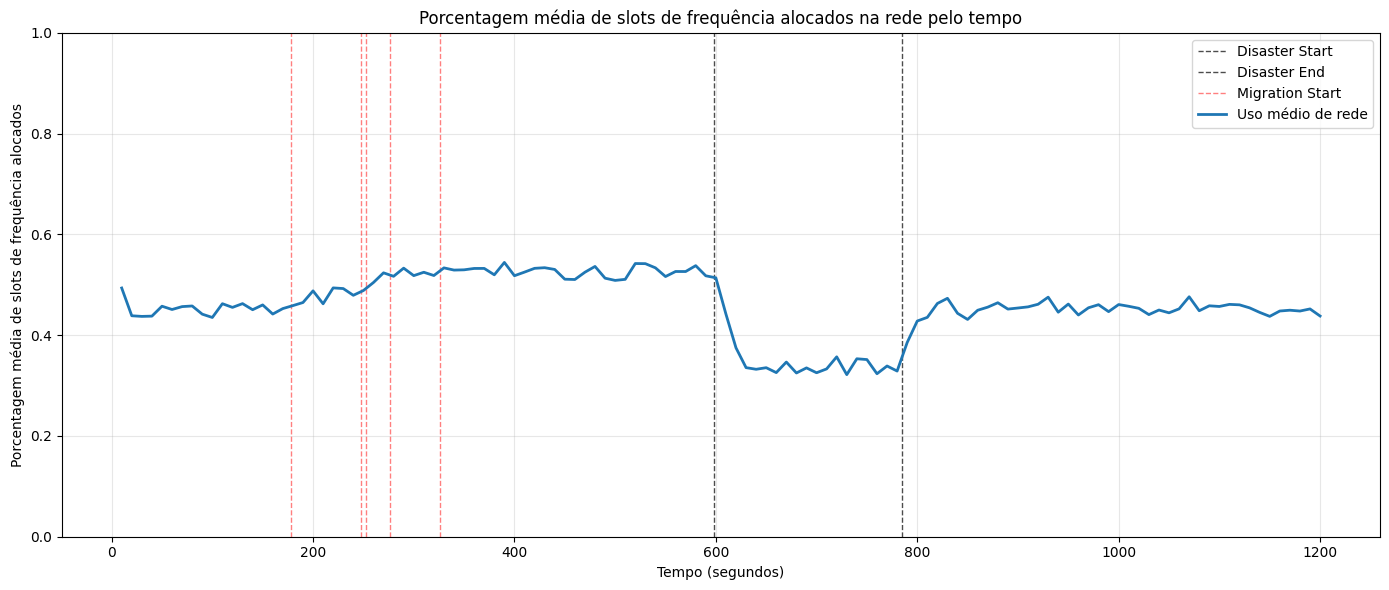

In [24]:
visualization.traffic_plots.plot_network_usage(dataframe1, TOPOLOGY, scenario=cenario1, numero_de_slots=NUMERO_DE_SLOTS)

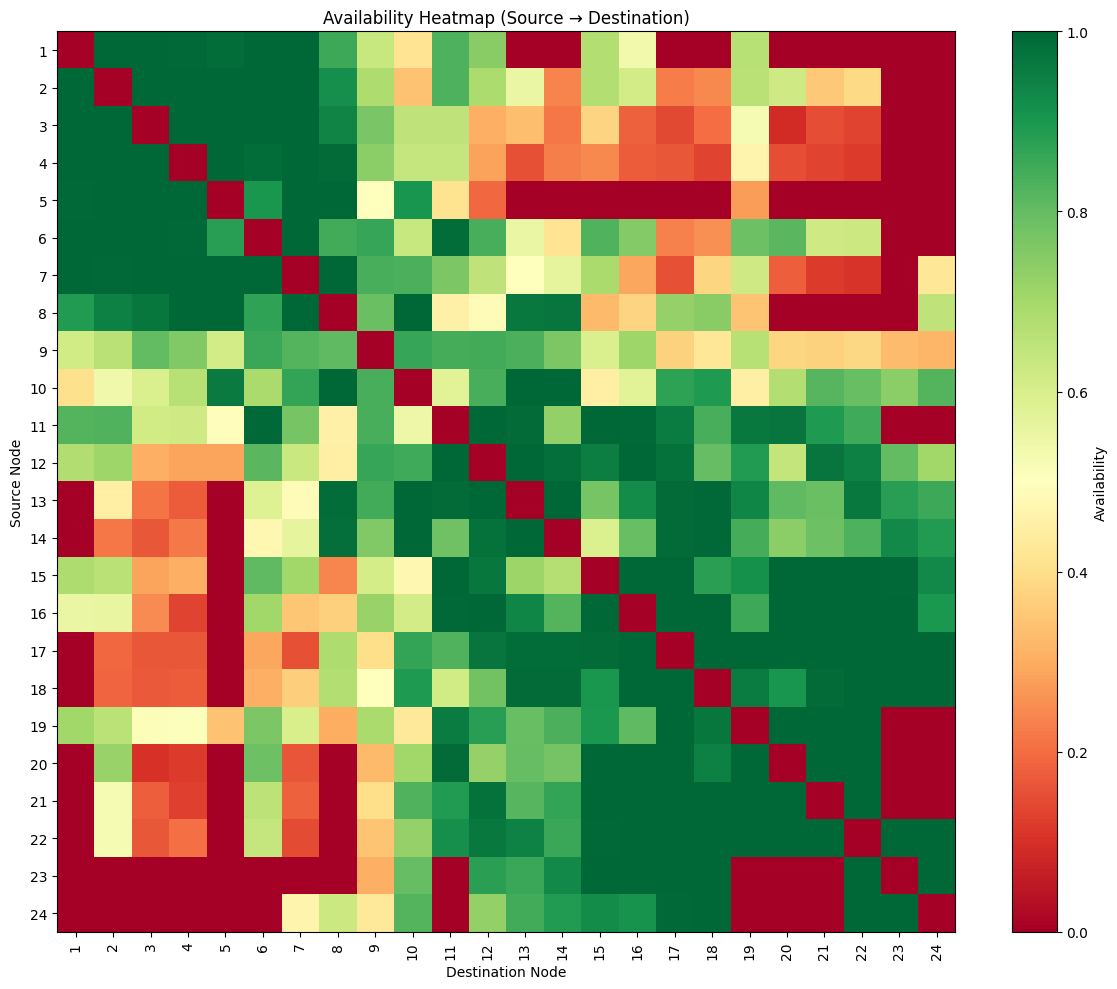

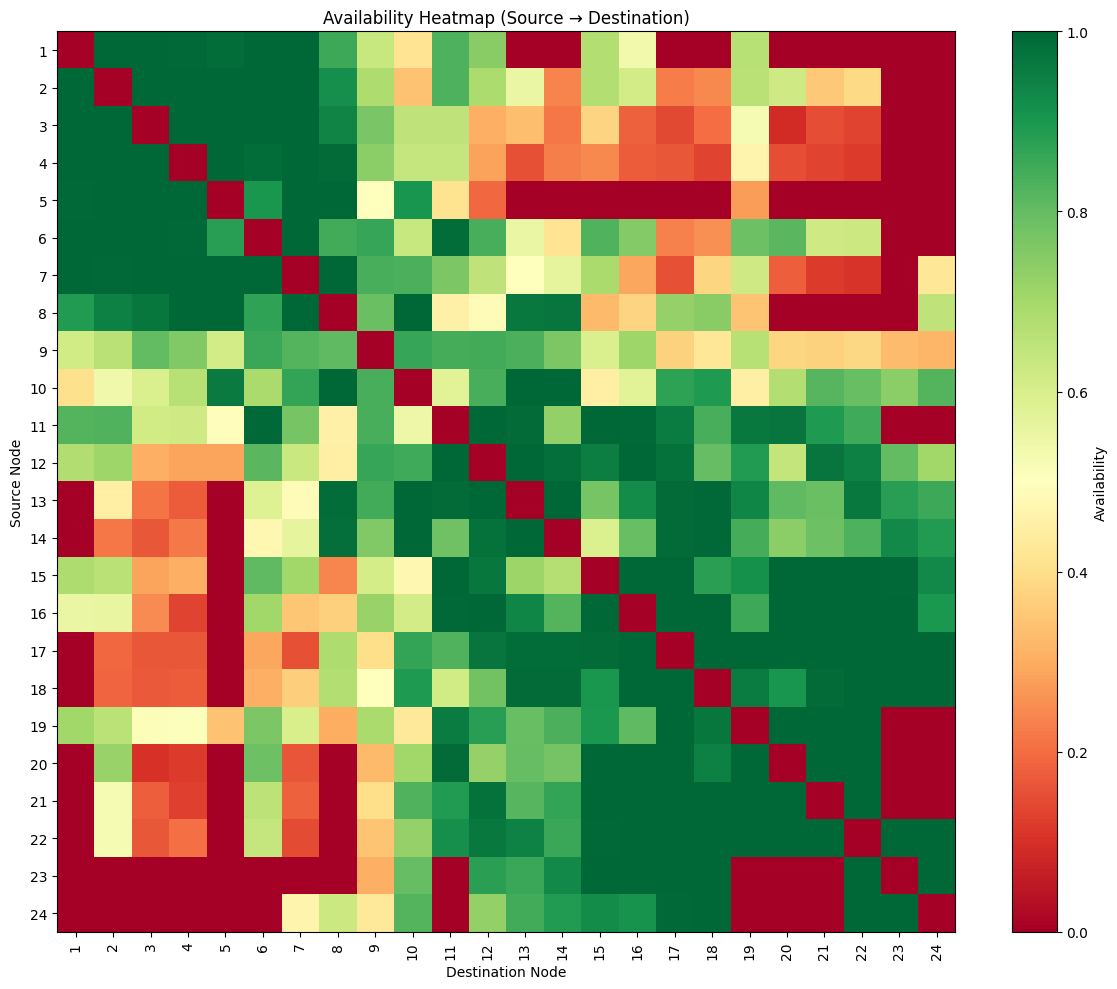

In [25]:
visualization.availability_plots.plot_availability_heatmap(dataframe1, TOPOLOGY)

In [26]:
numero_de_slots_dataframe1 = metrics_calculator.get_slots_allocated_during_disaster(dataframe1, DISASTER_START, DISASTER_END)
numero_de_slots_dataframe2 = metrics_calculator.get_slots_allocated_during_disaster(dataframe2, DISASTER_START, DISASTER_END)
print("numero de slots dataframe1", numero_de_slots_dataframe1)
print("numero de slots dataframe2", numero_de_slots_dataframe2)

NameError: name 'metrics_calculator' is not defined

Considerar fazer uma sliding window por distancia de par de nodes e considerar implementar bloqueio artificial em trafego intracomponente de maneira a facilitar alocação extra componente

analise comparativa de numero de slots alocados por node
